
Attempting to read file: Dirty Dataset Practice - Meal Survey Jess Ramos.xlsx
Successfully read the Excel file

First 5 rows of raw data:
   OrderID FirstName   LastName Gender     PhoneNumber  \
0      123    Jenny       Smith      F    770-123-4567   
1      456     JERRY        LEE      M        111-2345   
2      789  leonard         NaN    NaN  (303) 567-8910   
3       98      Brad    Johnson   Male      2223456789   
4      765     Juan   Fernandez   male       111111111   

                               Address  Age            LunchOrder  \
0   123 Sunshine Rd. Atlanta, GA 30033  350  Pizza, Salad, & Soda   
1  2333 Apricot St. ATL, Georgia 30033   56           Pizza/Water   
2          909 club dr. atlanta, 30033   19                 Pizza   
3               1344 Canvas Circle ATL   26          Salad & Soda   
4                                  NaN   20       water and pizza   

   ItemsOrdered  MealRating0-5  MealCostEstimated  
0             3            4.5               

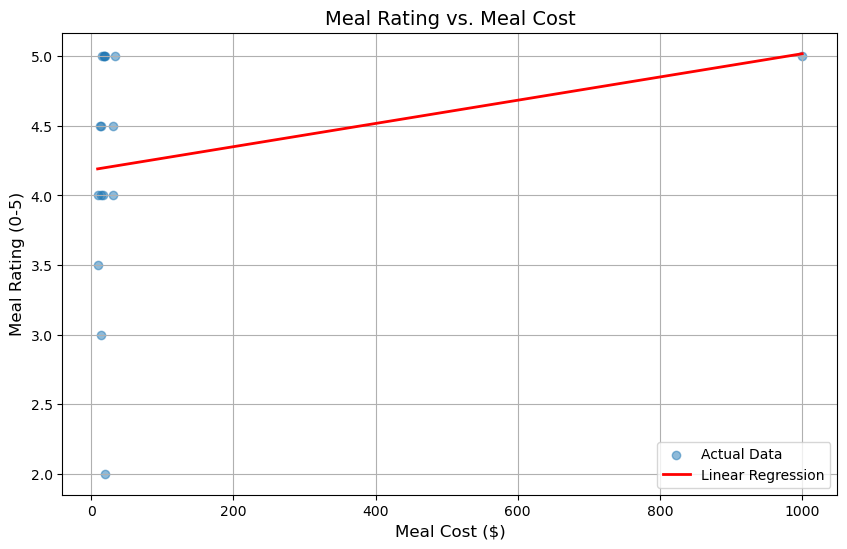


=== Simple Linear Regression Results ===
Coefficient: 0.0008
Intercept: 4.1834
R-squared: 0.0573

Interpretation:
Each dollar increase in meal cost is associated with a 0.0008 change in rating

Running Polynomial Regression: Age vs. Meal Rating


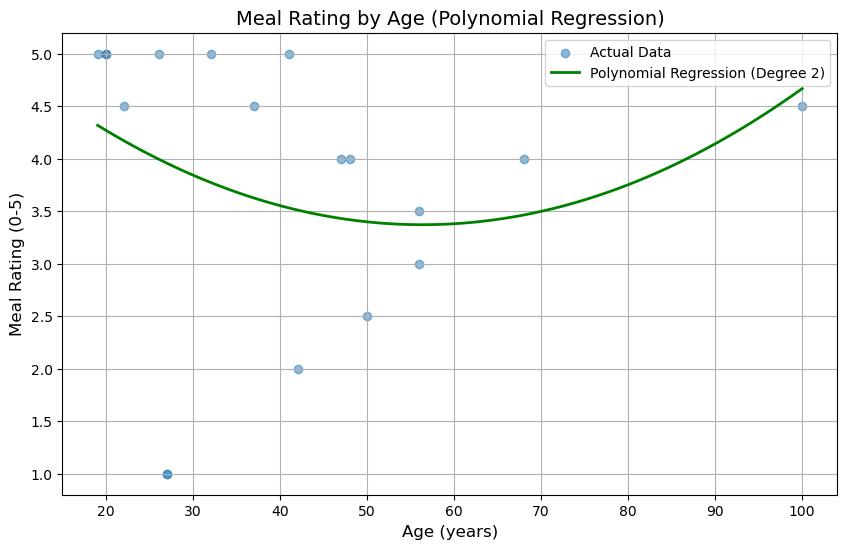


=== Polynomial Regression Results ===
Coefficients: [ 0.         -0.07654636  0.00067953]
Intercept: 5.5273
R-squared: 0.0885

Note: The polynomial terms capture non-linear relationships between age and meal rating

Running Multiple Linear Regression: Meal Rating vs. Age and Meal Cost


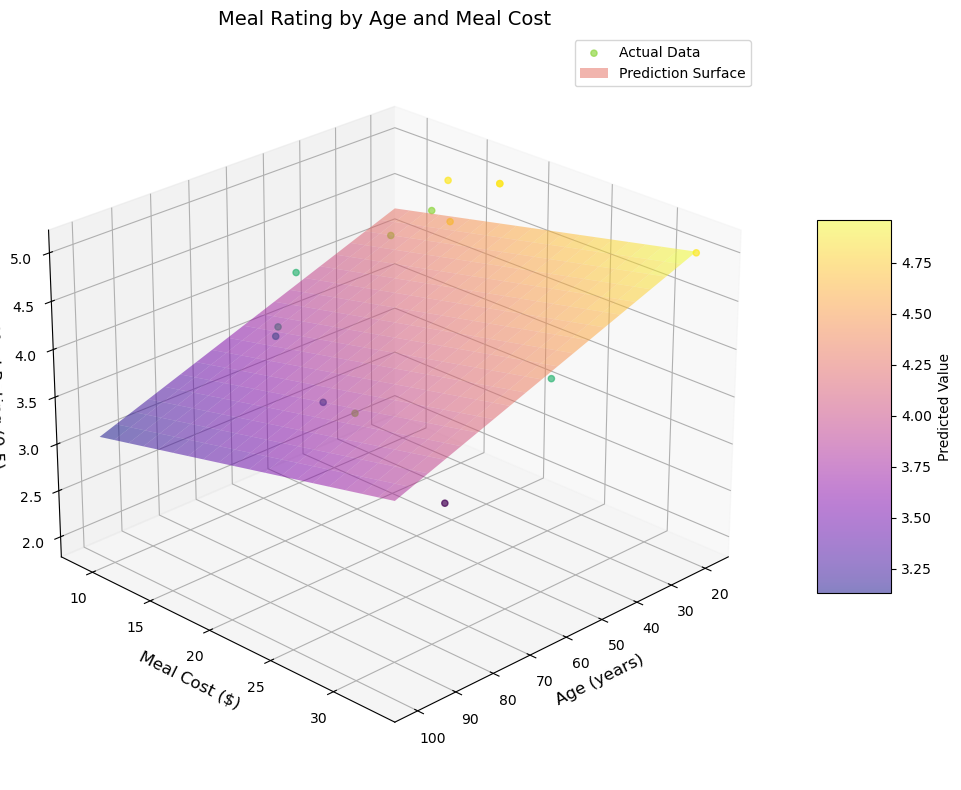


=== Multiple Regression Results ===
Age Coefficient: -0.0149
Meal Cost Coefficient: 0.0302
Intercept: 4.2971
R-squared: 0.1861

Interpretation:
Positive coefficients indicate higher predicted meal ratings


In [1]:
# Import packages with comprehensive error handling
import sys

def install_package(package):
    import subprocess
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"Successfully installed {package}")
        return True
    except Exception as e:
        print(f"Failed to install {package}: {e}")
        return False

try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.metrics import r2_score
    from mpl_toolkits.mplot3d import Axes3D
except ImportError as e:
    print(f"Import Error: {e}")
    print("Attempting to install required packages...")
    
    required_packages = ['pandas', 'numpy', 'matplotlib', 'scikit-learn']
    for pkg in required_packages:
        install_package(pkg)
    
    # Try importing again after installation attempts
    try:
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        from sklearn.linear_model import LinearRegression
        from sklearn.preprocessing import PolynomialFeatures
        from sklearn.metrics import r2_score
        from mpl_toolkits.mplot3d import Axes3D
    except ImportError as e:
        print(f"Still missing packages after installation attempt: {e}")
        sys.exit(1)

# Function to read Excel file with multiple fallback options
def read_excel_file(file_path):
    # Try different engines in order of preference
    engines_to_try = ['openpyxl', 'xlrd', 'odf', 'pyxlsb']
    
    for engine in engines_to_try:
        try:
            if engine == 'xlrd':
                # xlrd only supports .xls files in newer versions
                if file_path.endswith('.xlsx'):
                    print("Note: xlrd may not support .xlsx files in this version")
                return pd.read_excel(file_path, sheet_name='Sheet1', engine=engine)
            else:
                # First try without installing
                try:
                    return pd.read_excel(file_path, sheet_name='Sheet1', engine=engine)
                except ImportError:
                    # Try installing the engine
                    if install_package(engine):
                        return pd.read_excel(file_path, sheet_name='Sheet1', engine=engine)
        except Exception as e:
            print(f"Failed to read with {engine}: {str(e)[:100]}...")
            continue
    
    # If all engines fail, try converting to CSV
    print("\nAll Excel engines failed. Please consider:")
    print("1. Converting the file to CSV format")
    print("2. Installing one of these packages manually:")
    print("   pip install openpyxl (for .xlsx files)")
    print("   pip install xlrd (for .xls files)")
    print("   pip install odf (for .ods files)")
    print("   pip install pyxlsb (for .xlsb files)")
    raise ImportError("No suitable Excel reader engine available")

# Enhanced data cleaning function
def clean_data(df):
    # Make a copy to avoid SettingWithCopyWarning
    df_clean = df.copy()
    
    # Clean OrderID - handle decimal and missing values
    df_clean['OrderID'] = pd.to_numeric(df_clean['OrderID'], errors='coerce')
    df_clean['OrderID'] = df_clean['OrderID'].astype('Int64')
    
    # Clean names - handle missing values and formatting
    for col in ['FirstName', 'LastName']:
        if col in df_clean:
            df_clean[col] = df_clean[col].astype(str).str.strip().str.title()
            df_clean[col] = df_clean[col].replace({'Nan': None, '': None})
    
    # Clean gender - standardize to M/F/None
    if 'Gender' in df_clean:
        df_clean['Gender'] = df_clean['Gender'].astype(str).str.upper().str.strip().str[0]
        df_clean['Gender'] = df_clean['Gender'].replace({
            '': None, 
            'N': None,
            'MALE': 'M', 
            'FEMALE': 'F',
            'MA': 'M',
            'FE': 'F'
        })
    
    # Clean age - handle outliers and invalid values
    if 'Age' in df_clean:
        df_clean['Age'] = pd.to_numeric(df_clean['Age'], errors='coerce')
        df_clean['Age'] = df_clean['Age'].clip(10, 100)  # Reasonable age range
    
    # Clean meal rating - ensure 0-5 scale
    if 'MealRating0-5' in df_clean:
        df_clean['MealRating0-5'] = pd.to_numeric(df_clean['MealRating0-5'], errors='coerce')
        df_clean['MealRating0-5'] = df_clean['MealRating0-5'].clip(0, 5)
    
    # Clean meal cost - handle missing and invalid values
    if 'MealCostEstimated' in df_clean:
        df_clean['MealCostEstimated'] = pd.to_numeric(df_clean['MealCostEstimated'], errors='coerce')
        df_clean['MealCostEstimated'] = df_clean['MealCostEstimated'].replace(0, np.nan)
    
    # Clean items ordered - ensure numeric
    if 'ItemsOrdered' in df_clean:
        df_clean['ItemsOrdered'] = pd.to_numeric(df_clean['ItemsOrdered'], errors='coerce')
    
    return df_clean

# Visualization functions
def plot_regression(X, y, x_range, y_pred, title, xlabel, ylabel, color='red', label='Linear Regression'):
    plt.figur e(figsize=(10, 6))
    plt.scatter(X, y, alpha=0.5, label='Actual Data')
    plt.plot(x_range, y_pred, color=color, linewidth=2, label=label)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_3d_regression(X1, X2, y, model, title, xlabel, ylabel, zlabel):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create prediction grid
    x1_range = np.linspace(X1.min(), X1.max(), 20)
    x2_range = np.linspace(X2.min(), X2.max(), 20)
    X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)
    Z = model.predict(np.c_[X1_grid.ravel(), X2_grid.ravel()]).reshape(X1_grid.shape)
    
    # Plot actual data
    ax.scatter(X1, X2, y, c=y, cmap='viridis', alpha=0.7, label='Actual Data')
    
    # Plot prediction surface
    surf = ax.plot_surface(X1_grid, X2_grid, Z, alpha=0.5, cmap='plasma', label='Prediction Surface')
    
    # Customize view
    ax.view_init(elev=25, azim=45)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_zlabel(zlabel, fontsize=12)
    ax.set_title(title, fontsize=14)
    
    # Add colorbar
    fig.colorbar(surf, shrink=0.5, aspect=5, label='Predicted Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main analysis function
def analyze_meal_survey(file_path):
    try:
        # 1. Read data
        print(f"\nAttempting to read file: {file_path}")
        df = read_excel_file(file_path)
        print("Successfully read the Excel file")
        print("\nFirst 5 rows of raw data:")
        print(df.head())
        
        # 2. Clean data
        print("\nCleaning data...")
        df_clean = clean_data(df)
        print("Data cleaning completed successfully")
        print("\nFirst 5 rows of cleaned data:")
        print(df_clean.head())
        print("\nMissing values after cleaning:")
        print(df_clean.isna().sum())
        
        # 3. Simple Linear Regression: Meal Rating vs. Meal Cost
        print("\nRunning Simple Linear Regression: Meal Rating vs. Meal Cost")
        reg_df = df_clean[['MealRating0-5', 'MealCostEstimated']].dropna()
        
        if len(reg_df) < 2:
            print("Warning: Not enough data points for regression (need at least 2)")
        else:
            X = reg_df['MealCostEstimated'].values.reshape(-1, 1)
            y = reg_df['MealRating0-5'].values
            
            model = LinearRegression()
            model.fit(X, y)
            
            x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
            y_pred = model.predict(x_range)
            
            plot_regression(
                X, y, x_range, y_pred,
                'Meal Rating vs. Meal Cost',
                'Meal Cost ($)', 'Meal Rating (0-5)'
            )
            
            print("\n=== Simple Linear Regression Results ===")
            print(f"Coefficient: {model.coef_[0]:.4f}")
            print(f"Intercept: {model.intercept_:.4f}")
            print(f"R-squared: {r2_score(y, model.predict(X)):.4f}")
            print("\nInterpretation:")
            print(f"Each dollar increase in meal cost is associated with a {model.coef_[0]:.4f} change in rating")
        
        # 4. Polynomial Regression: Age vs. Meal Rating
        print("\nRunning Polynomial Regression: Age vs. Meal Rating")
        reg_df = df_clean[['Age', 'MealRating0-5']].dropna()
        
        if len(reg_df) < 3:
            print("Warning: Not enough data points for polynomial regression (need at least 3)")
        else:
            X = reg_df['Age'].values.reshape(-1, 1)
            y = reg_df['MealRating0-5'].values
            
            poly = PolynomialFeatures(degree=2)
            X_poly = poly.fit_transform(X)
            
            model = LinearRegression()
            model.fit(X_poly, y)
            
            x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
            x_range_poly = poly.transform(x_range)
            y_pred = model.predict(x_range_poly)
            
            plot_regression(
                X, y, x_range, y_pred,
                'Meal Rating by Age (Polynomial Regression)',
                'Age (years)', 'Meal Rating (0-5)',
                color='green', label='Polynomial Regression (Degree 2)'
            )
            
            print("\n=== Polynomial Regression Results ===")
            print(f"Coefficients: {model.coef_}")
            print(f"Intercept: {model.intercept_:.4f}")
            print(f"R-squared: {r2_score(y, model.predict(X_poly)):.4f}")
            print("\nNote: The polynomial terms capture non-linear relationships between age and meal rating")
        
        # 5. Multiple Linear Regression: Meal Rating vs. Age and Meal Cost
        print("\nRunning Multiple Linear Regression: Meal Rating vs. Age and Meal Cost")
        reg_df = df_clean[['Age', 'MealCostEstimated', 'MealRating0-5']].dropna()
        
        if len(reg_df) < 3:
            print("Warning: Not enough data points for multiple regression (need at least 3)")
        else:
            X = reg_df[['Age', 'MealCostEstimated']].values
            y = reg_df['MealRating0-5'].values
            
            model = LinearRegression()
            model.fit(X, y)
            
            plot_3d_regression(
                reg_df['Age'], reg_df['MealCostEstimated'], y, model,
                'Meal Rating by Age and Meal Cost',
                'Age (years)', 'Meal Cost ($)', 'Meal Rating (0-5)'
            )
            
            print("\n=== Multiple Regression Results ===")
            print(f"Age Coefficient: {model.coef_[0]:.4f}")
            print(f"Meal Cost Coefficient: {model.coef_[1]:.4f}")
            print(f"Intercept: {model.intercept_:.4f}")
            print(f"R-squared: {r2_score(y, model.predict(X)):.4f}")
            print("\nInterpretation:")
            print("Positive coefficients indicate higher predicted meal ratings")
    
    except Exception as e:
        print(f"\nERROR during analysis: {e}")
        print("Please check:")
        print("- The file exists and is accessible")
        print("- You have the required packages installed")
        print("- The data format matches expectations")
        raise

# Run the analysis
if __name__ == "__main__":
    file_path = 'Dirty Dataset Practice - Meal Survey Jess Ramos.xlsx'
    
    try:
        analyze_meal_survey(file_path)
    except Exception as e:
        print(f"\nAnalysis failed: {e}")
        print("\nTroubleshooting steps:")
        print("1. Make sure the file exists at the specified path")
        print("2. Try converting the Excel file to CSV and modify the code to use pd.read_csv()")
        print("3. Install required packages manually:")
        print("   pip install pandas numpy matplotlib scikit-learn openpyxl xlrd")
        print("4. Check for any special characters or formatting issues in the Excel file")

In [2]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def read_excel_file(file_path):
    # Implementation from original code
    pass

def clean_data(df):
    # Implementation from original code
    pass

def analyze_simple_linear_regression(file_path):
    try:
        # Read and clean data
        df = read_excel_file(file_path)
        df_clean = clean_data(df)
        
        # Prepare data for regression
        reg_df = df_clean[['MealRating0-5', 'MealCostEstimated']].dropna()
        
        if len(reg_df) < 2:
            print("Warning: Not enough data points for regression (need at least 2)")
            return
        
        X = reg_df['MealCostEstimated'].values.reshape(-1, 1)
        y = reg_df['MealRating0-5'].values
        
        # Create and fit model
        model = LinearRegression()
        model.fit(X, y)
        
        # Generate predictions for visualization
        x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
        y_pred = model.predict(x_range)
        
        # Plot results
        plt.figure(figsize=(10, 6))
        plt.scatter(X, y, alpha=0.5, label='Actual Data')
        plt.plot(x_range, y_pred, color='red', linewidth=2, label='Linear Regression')
        plt.title('Meal Rating vs. Meal Cost', fontsize=14)
        plt.xlabel('Meal Cost ($)', fontsize=12)
        plt.ylabel('Meal Rating (0-5)', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Print results
        print("\n=== Simple Linear Regression Results ===")
        print(f"Coefficient: {model.coef_[0]:.4f}")
        print(f"Intercept: {model.intercept_:.4f}")
        print(f"R-squared: {r2_score(y, model.predict(X)):.4f}")
        print("\nInterpretation:")
        print(f"Each dollar increase in meal cost is associated with a {model.coef_[0]:.4f} change in rating")
        
    except Exception as e:
        print(f"Error during analysis: {e}")

# Run the analysis
if __name__ == "__main__":
    file_path = 'Dirty Dataset Practice - Meal Survey Jess Ramos.xlsx'
    analyze_simple_linear_regression(file_path)

Error during analysis: 'NoneType' object is not subscriptable


In [4]:
pip install pandas scikit-learn matplotlib openpyxl

Note: you may need to restart the kernel to use updated packages.


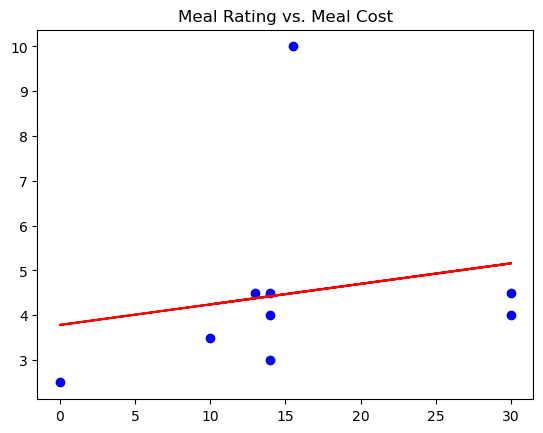

Coefficient: 0.045816890292028414
Intercept: 3.7847474348855563


In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Read data and drop missing values
df = pd.read_excel('Dirty Dataset Practice - Meal Survey Jess Ramos.xlsx').dropna()

# Prepare data
X = df[['MealCostEstimated']].values
y = df['MealRating0-5'].values

# Create and fit model
model = LinearRegression()
model.fit(X, y)

# Plot
plt.scatter(X, y, color='blue')
plt.plot(X, model.predict(X), color='red')
plt.title('Meal Rating vs. Meal Cost')
plt.show()

print("Coefficient:", model.coef_[0])
print("Intercept:", model.intercept_)

In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Read data and fill missing values
df = pd.read_excel('Dirty Dataset Practice - Meal Survey Jess Ramos.xlsx')
df = df.fillna(df.mean())

# Rest of the code remains the same...

TypeError: can only concatenate str (not "int") to str